In [1]:
import gc
gc.collect()

227

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
print("Number of available GPU's: ", len(tf.config.experimental.list_physical_devices("GPU")))

Number of available GPU's:  1


In [5]:
import os
if "CNN" in os.path.abspath(os.curdir): os.chdir("..")
BASE_DIR = os.path.abspath(os.curdir)
BASE_DIR

'D:\\TheCompleteML\\projects'

In [6]:
data_dir = os.path.join(BASE_DIR, "datasets", "classification", "flowers")

In [7]:
data_dirs = [os.path.join(data_dir, dir_) for dir_ in os.listdir(data_dir) if "processed" not in dir_]

In [8]:
data_dirs

['D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\daisy',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\dandelion',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\rose',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\sunflower',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\tulip']

## Preprocessing

In [72]:
import random
from skimage import io

class loading_and_splitting:
    
    def __init__(self, data_dirs, dims, channels=3, target_dir=data_dir, split_count=10):
        self.total_images = 0
        self.minh = np.inf
        self.minw = np.inf
        self.dims = dims
        self.channels = channels
        self.target_dir = target_dir
        self.split_count = split_count
        self.data_dirs = data_dirs
        self.class_map = {k:v.split("\\")[-1] for k, v in enumerate(data_dirs)}
        
        self.header_list = [f"x{i}" for i in range(self.dims[0]*self.dims[1]*self.channels)] + ["label"]
        self.sample_list = [random.sample(range(len(os.listdir(path))), 
                                          len(os.listdir(path))) for path in data_dirs]
        for item in self.sample_list:
            self.total_images += len(item)
        self.generate_samples()
        self.max_train_instance = len(self.train_seq)
        self.max_valid_instance = len(self.valid_seq)
        self.max_test_instance = len(self.test_seq)
    
    def generate_csvs(self):
        header_list = [f"x{i}" for i in range(self.dims[0]*self.dims[1]*self.channels)] + ["label"]
        for set_ in ["train", "valid", "test"]:
            with open(os.path.join(self.target_dir, f"{set_}.csv"), "w") as f:
                df = pd.DataFrame(list(), columns=header_list)
                df.to_csv(f, index=False)
                
    def generate_samples(self):
        self.sample_seq = random.sample(range(self.total_images), self.total_images)
        self.train_seq = self.sample_seq[:int(len(self.sample_seq)*0.8)]
        self.valid_seq = self.sample_seq[int(len(self.sample_seq)*0.8):int(len(self.sample_seq)*0.9)]
        self.test_seq = self.sample_seq[int(len(self.sample_seq)*0.9):]
    
    def crop_image(self, image):
        h, w, d = image.shape
        if h >= self.minh and w >= self.minw:
            image = image[int(h/2)-64:int(h/2)+64, 
                          int(w/2)-64:int(w/2)+64, 
                          :]
            return image
    
    def crop_or_pad(self, image):
        image = tf.image.resize_with_crop_or_pad(image, self.dims[0], self.dims[0])
        return image.numpy()
    
    def shuffle_and_save(self):
        empty = []
        train = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        valid = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        test = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        count = 0
        while len(empty) != len(self.data_dirs):
            sel_dir = np.random.randint(0, len(self.data_dirs))
            if sel_dir in empty: continue
            dir_ = self.data_dirs[sel_dir]
            if not self.sample_list[sel_dir]:
                empty.append(sel_dir)
            else:
                count += 1
                print(f"Processing: {count}")
                sel_image = self.sample_list[sel_dir].pop()
                image = io.imread(os.path.join(dir_, os.listdir(dir_)[sel_image]))
                
                h, w, d = image.shape
                if h < self.minh: self.minh = h
                if w < self.minw: self.minw = w
                if self.minh < self.dims[0]: self.minh = self.dims[0]
                if self.minw < self.dims[1]: self.minw = self.dims[1]
                
                # image = self.crop_image(image)
                image = self.crop_or_pad(image)
                
                if not isinstance(image, np.ndarray): continue
                if sel_image in self.train_seq: 
                    train = np.append(train, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
                elif sel_image in self.valid_seq: 
                    valid = np.append(valid, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
                elif sel_image in self.test_seq: 
                    test = np.append(test, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
        
        train = train[1:, :]
        valid = valid[1:, :]
        test = test[1:, :]
        
        for prefix, arr in zip(["train", "valid", "test"], [train, valid, test]):
            self.split_and_save(arr, os.path.join(self.target_dir, "processed", prefix), prefix)
        
    def split_and_save(self, arr, target_dir, prefix):
        os.makedirs(target_dir, exist_ok=True)
        for i in range(self.split_count):
            df = pd.DataFrame(arr[i*int(arr.shape[0]//self.split_count):(i+1)*int(arr.shape[0]//self.split_count), :], 
                             columns=self.header_list)
            df.to_csv(os.path.join(target_dir, "{}_{}.csv".format(prefix, i+1)), index=False)

In [73]:
dims = (150, 150)
channels = 3
split_count = 10
n_features = dims[0] * dims[1] * channels
ls = loading_and_splitting(data_dirs=data_dirs, dims=dims, channels=channels, target_dir=data_dir)
class_map = ls.class_map
max_train_instance = (ls.max_train_instance//split_count)*split_count
max_valid_instance = (ls.max_valid_instance//split_count)*split_count
max_test_instance = (ls.max_test_instance//split_count)*split_count
class_map
# ls.shuffle_and_save()

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

In [14]:
set_dir = os.path.join(data_dir, "processed")
train_paths = [f"{os.path.join(set_dir, 'train')}\\{item}" for item in os.listdir(os.path.join(set_dir, "train"))]
valid_paths = [f"{os.path.join(set_dir, 'valid')}\\{item}" for item in os.listdir(os.path.join(set_dir, "valid"))]
test_paths = [f"{os.path.join(set_dir, 'test')}\\{item}" for item in os.listdir(os.path.join(set_dir, "test"))]

In [20]:
data_augmentation = tf.keras.Sequential([keras.layers.RandomFlip("horizontal_and_vertical"), 
                                         keras.layers.RandomRotation(0.2),
                                         keras.layers.RandomContrast(0.5),
                                         keras.layers.RandomZoom((-0.3, 0.3), (-0.3, 0.3))
                                         ])

def preprocess(line, augmentation=False):
    defs = [tf.constant([], dtype = tf.float32)] * (n_features + 1)
    xy = tf.io.decode_csv(line, record_defaults=defs)
    X = tf.stack(xy[:-1])
    y = tf.stack(xy[-1:])
    
    # prcessing steps
    X = tf.divide(X, 255)
    X = tf.reshape(X, [dims[0], dims[1], channels])
    if augmentation:
        X = data_augmentation(X)
        X = tf.image.rot90(X)
        X = tf.image.random_brightness(X, 0.2)
    
    return X, y


def preprocess_test(X):
    # prcessing steps
    
    X = tf.image.resize_with_crop_or_pad(X, 150 ,150)
    X = data_augmentation(X)
    X = tf.image.rot90(X)
    X = tf.image.random_brightness(X, 0.2)
    X = tf.divide(X, 255)
    
    return X

In [21]:
from functools import partial

def read_csv_pipeline(paths, 
                      n_readers, 
                      shuffle_buffer_size, 
                      n_read_threds, 
                      n_parse_threads, 
                      batch_size, 
                      augmentation=False):
    
    filepaths = tf.data.Dataset.list_files(paths, seed=42)
    dataset = filepaths.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size)
    if augmentation: dataset = dataset.repeat()
    dataset = dataset.map(partial(preprocess, augmentation=augmentation), num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

In [22]:
n_readers = 5
shuffle_buffer_size = 400
n_read_threads = None
n_parse_threads = 5
batch_size = 32

train_set = read_csv_pipeline(train_paths, 
                              n_readers, 
                              shuffle_buffer_size, 
                              n_read_threads, 
                              n_parse_threads, 
                              batch_size, 
                              augmentation=True)

valid_set = read_csv_pipeline(valid_paths, 
                              n_readers, 
                              shuffle_buffer_size, 
                              n_read_threads, 
                              n_parse_threads, 
                              batch_size, 
                              augmentation=False)

test_set = read_csv_pipeline(test_paths, 
                             n_readers, 
                             shuffle_buffer_size, 
                             n_read_threads, 
                             n_parse_threads, 
                             batch_size, 
                             augmentation=False)

### Model Training

In [15]:
class ResidualLayer(keras.layers.Layer):
    
    def __init__(self, fm, strides=1, ksize=3, padding="same", activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.fm = fm
        self.ksize = ksize
        self.strides = strides
        self.padding = padding
        self.activation = keras.activations.get(activation)
        self.normalization = keras.layers.BatchNormalization()
        self.mainc_layers = [keras.layers.Conv2D(self.fm, 
                                                 kernel_size=self.ksize, 
                                                 strides=self.strides, 
                                                 padding=self.padding, 
                                                 use_bias=False),
                            self.normalization, 
                            self.activation,
                            keras.layers.Conv2D(self.fm, 
                                                kernel_size=self.ksize, 
                                                strides=1, 
                                                padding=self.padding, 
                                                use_bias=False),
                            self.normalization]
        self.skipc_layers = []
        if strides > 1:
            self.skipc_layers = [keras.layers.Conv2D(self.fm, 
                                                     kernel_size=1, 
                                                     strides=self.strides, 
                                                     padding=self.padding,
                                                     use_bias=False),
                                self.normalization]
    def get_config(self):
        config = super().get_config()
        config.update({"fm": self.fm,
                        "ksize": self.ksize,
                        "strides": self.strides,
                        "padding": self.padding,
                        "activation": self.activation
                        })
        return config
    
    def call(self, inputs):
        z = inputs
        for layer in self.mainc_layers:
            z = layer(z)
        skip_z = inputs
        for layer in self.skipc_layers:
            skip_z = layer(skip_z)
        return self.activation(z+skip_z)

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def resnet_model():

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=64, kernel_size=7, 
                                  strides=2, padding="same", 
                                  use_bias=False,
                                  input_shape=[dims[0], dims[1], channels]))
    model.add(keras.layers.Normalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2)) # pool size is three, strides is 2 and padding is same
    pfm = 64
    for fm in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 6: # 512 should be repeated 3 times instead of 6
        strides = 1 if fm == pfm else 2
        model.add(ResidualLayer(fm=fm, strides=strides))
        pfm = fm
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
              optimizer=keras.optimizers.Nadam(),
              metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "flowers_cnn_with_resnet_model.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks    

In [24]:
model, callbacks = resnet_model()

In [26]:
history = model.fit(train_set, epochs=25, validation_data=valid_set,
                   callbacks=callbacks)

Epoch 1/25
325/325 [==============================] - 534s 2s/step - loss: 1.5389 - sparse_categorical_accuracy: 0.4515 - val_loss: 2.0277 - val_sparse_categorical_accuracy: 0.2937
Epoch 2/25
325/325 [==============================] - 445s 1s/step - loss: 1.0884 - sparse_categorical_accuracy: 0.5789 - val_loss: 1.4646 - val_sparse_categorical_accuracy: 0.3603
Epoch 3/25
325/325 [==============================] - 351s 1s/step - loss: 0.9444 - sparse_categorical_accuracy: 0.6408 - val_loss: 1.6137 - val_sparse_categorical_accuracy: 0.2341
Epoch 4/25
325/325 [==============================] - 356s 1s/step - loss: 0.8733 - sparse_categorical_accuracy: 0.6674 - val_loss: 1.9676 - val_sparse_categorical_accuracy: 0.2389
Epoch 5/25
325/325 [==============================] - 349s 1s/step - loss: 0.7960 - sparse_categorical_accuracy: 0.6980 - val_loss: 1.6316 - val_sparse_categorical_accuracy: 0.3865
Epoch 6/25
325/325 [==============================] - 360s 1s/step - loss: 0.7178 - sparse_cate

In [63]:
def plot_losses_and_accuracy(history, ylim=(0, 1)):
    pd.DataFrame(history.history).plot(figsize=(8, 5)) 
    plt.grid(True) 
    plt.gca().set_ylim(*ylim) # set the vertical range to [0-1] 
    plt.show()

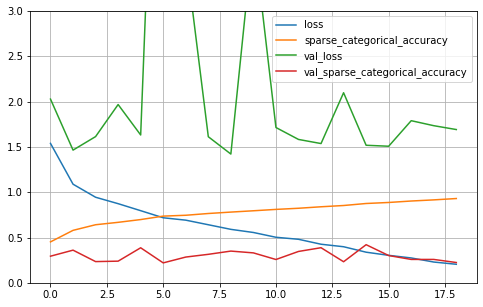

In [67]:
plot_losses_and_accuracy(history, ylim=(0, 3))

##### Observations

Here model clearly seems to have overfitting. So we need to put some constraints to reduce the overfitting

Constraints to reduce overfitting for CNN
- Reduce layers and hidden units
- Regularization
- Weight Initilizatin
- Dropout Regularization
- Weight Constraints
- Other methods

In [187]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de():
    """
    name ecodes the model architecture
    cnn followed by max pooling repeated three times, followed by dense layer
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels], 
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False, 
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False, 
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="nadam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "flowers_cnn_mp_r3_de.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [188]:
model, callbacks = cnn_mp_r3_de()

In [192]:
history = model.fit(train_set, epochs=25, 
                    validation_data=valid_set, callbacks=callbacks)

Epoch 1/25
865/865 [==============================] - 901s 1s/step - loss: 1.2241 - sparse_categorical_accuracy: 0.4967 - val_loss: 1.0431 - val_sparse_categorical_accuracy: 0.5890
Epoch 2/25
865/865 [==============================] - 919s 1s/step - loss: 1.0072 - sparse_categorical_accuracy: 0.6105 - val_loss: 0.9015 - val_sparse_categorical_accuracy: 0.6292
Epoch 3/25
865/865 [==============================] - 950s 1s/step - loss: 0.8769 - sparse_categorical_accuracy: 0.6632 - val_loss: 0.8222 - val_sparse_categorical_accuracy: 0.6676
Epoch 4/25
865/865 [==============================] - 920s 1s/step - loss: 0.8119 - sparse_categorical_accuracy: 0.6933 - val_loss: 0.7644 - val_sparse_categorical_accuracy: 0.7042
Epoch 5/25
865/865 [==============================] - 913s 1s/step - loss: 0.7554 - sparse_categorical_accuracy: 0.7133 - val_loss: 0.7606 - val_sparse_categorical_accuracy: 0.7065
Epoch 6/25
865/865 [==============================] - 923s 1s/step - loss: 0.6971 - sparse_cate

##### Observations

Here we have a vanishing gradient problem, we can use following aproch to reduce it. 

- He normal initializer with relu activations
- Batch Normalization
- Add some layers with reidualnetwork 
- Dropouts should be added to reduce the overfitting


One approch is to use lower layers of already trained netowrk and implement some normalization, initilization and dropout techniques to appended layers and make freeze all the pretrained layer during training this updated model. But important point is that tranfer learning aproch will not work well for small dense network as compare to DNN,beacause lower layers in DNN learned more general patterns so can be usefull and improved.

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def mini_resnet_9cl():
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=64,
                                kernel_size=5, 
                                strides=2, 
                                padding="same", 
                                use_bias=False, 
                                input_shape=[dims[0], dims[1], channels]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
    pfm = 64
    for fm in [64, 128, 256, 512]:
        strides = 1 if pfm == fm else 2
        model.add(ResidualLayer(fm=fm, strides=strides))
        pfm = fm
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="nadam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "mini_resnet_9cl.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [17]:
model, callbacks = mini_resnet_9cl()

In [18]:
history = model.fit(train_set, epochs=25, validation_data=valid_set, callbacks=callbacks)

Epoch 1/25
865/865 [==============================] - 953s 1s/step - loss: 1.0987 - sparse_categorical_accuracy: 0.5666 - val_loss: 1.6325 - val_sparse_categorical_accuracy: 0.2571
Epoch 2/25
865/865 [==============================] - 903s 1s/step - loss: 0.8711 - sparse_categorical_accuracy: 0.6618 - val_loss: 1.8039 - val_sparse_categorical_accuracy: 0.2342
Epoch 3/25
865/865 [==============================] - 837s 966ms/step - loss: 0.7801 - sparse_categorical_accuracy: 0.6971 - val_loss: 1.7594 - val_sparse_categorical_accuracy: 0.2363
Epoch 4/25
865/865 [==============================] - 838s 968ms/step - loss: 0.7111 - sparse_categorical_accuracy: 0.7254 - val_loss: 1.6702 - val_sparse_categorical_accuracy: 0.2756
Epoch 5/25
865/865 [==============================] - 852s 983ms/step - loss: 0.6415 - sparse_categorical_accuracy: 0.7535 - val_loss: 1.8698 - val_sparse_categorical_accuracy: 0.2991
Epoch 6/25
865/865 [==============================] - 873s 1s/step - loss: 0.5834 - sp

In [26]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_bn_mp_r3_de():
    """
    name ecodes the model architecture
    cnn followed by batch normlization and max pooling repeated four times, followed by dense layer
    also modified, padding as valid, and strides as 2 for cnn and padding as same for max-pooling
    dropour rate is decreased
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=1,  
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels], 
                                  ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1,  
                                  use_bias=False, 
                                  ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1,  
                                  use_bias=False, 
                                  ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="nadam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "cnn_bn_mp_r3_de.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [27]:
model, callbacks = cnn_bn_mp_r3_de()

In [28]:
history = model.fit(train_set, epochs=25, validation_data=valid_set, callbacks=callbacks)

Epoch 1/25
865/865 [==============================] - 18757s 22s/step - loss: 1.7212 - sparse_categorical_accuracy: 0.2415 - val_loss: 1.6023 - val_sparse_categorical_accuracy: 0.2405
Epoch 2/25
865/865 [==============================] - 873s 1s/step - loss: 1.5990 - sparse_categorical_accuracy: 0.2434 - val_loss: 1.6027 - val_sparse_categorical_accuracy: 0.2405
Epoch 3/25
865/865 [==============================] - 846s 974ms/step - loss: 1.5990 - sparse_categorical_accuracy: 0.2434 - val_loss: 1.6027 - val_sparse_categorical_accuracy: 0.2405
Epoch 4/25
865/865 [==============================] - 833s 962ms/step - loss: 1.5990 - sparse_categorical_accuracy: 0.2434 - val_loss: 1.6026 - val_sparse_categorical_accuracy: 0.2405
Epoch 5/25
865/865 [==============================] - 830s 958ms/step - loss: 1.5990 - sparse_categorical_accuracy: 0.2434 - val_loss: 1.6024 - val_sparse_categorical_accuracy: 0.2405
Epoch 6/25
865/865 [==============================] - 833s 962ms/step - loss: 1.599

 ##### Observations
 
 Here, clearly the models stops learning from the start is may be due to batch normalization layer, which is needed only for deep neural network not the shallow one

## Transfer Learning On ResNet

In [67]:
from functools import partial

def preprocess_tran_ler(line, 
                        augmentation=False, 
                        resize=(224, 224)):
    defs = [tf.constant([], dtype = tf.float32)] * (n_features + 1)
    xy = tf.io.decode_csv(line, record_defaults=defs)
    X = tf.stack(xy[:-1])
    y = tf.stack(xy[-1:])
    
    # prcessing steps
    X = tf.reshape(X, [dims[0], dims[1], channels])
    X = tf.image.resize(X, size=resize)
    if augmentation:
        X = data_augmentation(X)
        X = tf.image.rot90(X)
        X = tf.image.random_brightness(X, 0.2)
    X = keras.applications.resnet50.preprocess_input(X)
    return X, y


def read_csv_pipeline_tran_ler(paths, 
                               n_readers, 
                               shuffle_buffer_size, 
                               n_read_threds, 
                               n_parse_threads, 
                               batch_size, 
                               augmentation=False,
                               resize=(224, 224)):
    
    filepaths = tf.data.Dataset.list_files(paths, seed=42)
    dataset = filepaths.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size)
    if augmentation: dataset = dataset.repeat()
    dataset = dataset.map(partial(preprocess_tran_ler, augmentation=augmentation, resize=resize), num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

In [68]:
n_readers = 5
shuffle_buffer_size = 400
n_read_threads = None
n_parse_threads = 5
batch_size = 32
resize = (224, 224)

train_set = read_csv_pipeline_tran_ler(train_paths, 
                              n_readers, 
                              shuffle_buffer_size, 
                              n_read_threads, 
                              n_parse_threads, 
                              batch_size, 
                              augmentation=True,
                              resize=resize)

valid_set = read_csv_pipeline_tran_ler(valid_paths, 
                              n_readers, 
                              shuffle_buffer_size, 
                              n_read_threads, 
                              n_parse_threads, 
                              batch_size, 
                              augmentation=False,
                              resize=resize)

test_set = read_csv_pipeline_tran_ler(test_paths, 
                             n_readers, 
                             shuffle_buffer_size, 
                             n_read_threads, 
                             n_parse_threads, 
                             batch_size, 
                             augmentation=False,
                             resize=resize)

In [31]:
base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)

94781440/94765736 [==============================] - 29s 0us/step


### Tunning Optimizer

In [39]:
def transfer_learning_on_resnet():
    avg = keras.layers.GlobalAvgPool2D()(base_model.output)
    output = keras.layers.Dense(5, activation="softmax")(avg)
    model = keras.Model(inputs=base_model.input, outputs=output)
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="nadam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "transfer_learning_on_resnet.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks, base_model

In [40]:
model, callbacks, base_model = transfer_learning_on_resnet()

In [41]:
for layer in base_model.layers:
    layer.trainable = False

In [44]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9*max_train_instance/batch_size),
                    validation_data=valid_set, 
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - ETA: 0s - loss: 0.8026 - sparse_categorical_accuracy: 0.6962

D:\TheCompleteML\env\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


97/97 [==============================] - 283s 3s/step - loss: 0.8026 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.4972 - val_sparse_categorical_accuracy: 0.8143
Epoch 2/5
97/97 [==============================] - 250s 3s/step - loss: 0.4719 - sparse_categorical_accuracy: 0.8299 - val_loss: 0.4191 - val_sparse_categorical_accuracy: 0.8690
Epoch 3/5
97/97 [==============================] - 250s 3s/step - loss: 0.4055 - sparse_categorical_accuracy: 0.8483 - val_loss: 0.3964 - val_sparse_categorical_accuracy: 0.8714
Epoch 4/5
97/97 [==============================] - 242s 3s/step - loss: 0.3605 - sparse_categorical_accuracy: 0.8715 - val_loss: 0.3730 - val_sparse_categorical_accuracy: 0.8833
Epoch 5/5
97/97 [==============================] - 146s 2s/step - loss: 0.3399 - sparse_categorical_accuracy: 0.8808 - val_loss: 0.3595 - val_sparse_categorical_accuracy: 0.8786


In [48]:
def transfer_learning_on_resnet():
    avg = keras.layers.GlobalAvgPool2D()(base_model.output)
    output = keras.layers.Dense(5, activation="softmax")(avg)
    model = keras.Model(inputs=base_model.input, outputs=output)
    
    optimizer = keras.optimizers.SGD(learning_rate=2e-2, momentum=0.9, decay=0.1)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer,
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "transfer_learning_on_resnet.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks, base_model

In [49]:
model, callbacks, base_model = transfer_learning_on_resnet()

In [50]:
for layer in base_model.layers:
    layer.trainable = False

In [51]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9*max_train_instance/batch_size),
                    validation_data=valid_set, 
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - ETA: 0s - loss: 0.9586 - sparse_categorical_accuracy: 0.7568

D:\TheCompleteML\env\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


97/97 [==============================] - 150s 2s/step - loss: 0.9586 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.5401 - val_sparse_categorical_accuracy: 0.8595
Epoch 2/5
97/97 [==============================] - 147s 2s/step - loss: 0.5230 - sparse_categorical_accuracy: 0.8521 - val_loss: 0.4750 - val_sparse_categorical_accuracy: 0.8667
Epoch 3/5
97/97 [==============================] - 149s 2s/step - loss: 0.4292 - sparse_categorical_accuracy: 0.8660 - val_loss: 0.4569 - val_sparse_categorical_accuracy: 0.8690
Epoch 4/5
97/97 [==============================] - 148s 2s/step - loss: 0.4035 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.4492 - val_sparse_categorical_accuracy: 0.8571
Epoch 5/5
97/97 [==============================] - 154s 2s/step - loss: 0.3922 - sparse_categorical_accuracy: 0.8708 - val_loss: 0.4189 - val_sparse_categorical_accuracy: 0.8762


In [52]:
def transfer_learning_on_resnet():
    avg = keras.layers.GlobalAvgPool2D()(base_model.output)
    output = keras.layers.Dense(5, activation="softmax")(avg)
    model = keras.Model(inputs=base_model.input, outputs=output)
    
    optimizer = keras.optimizers.SGD(learning_rate=2e-2, momentum=0.9)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer,
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "transfer_learning_on_resnet.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks, base_model

In [53]:
model, callbacks, base_model = transfer_learning_on_resnet()

In [54]:
for layer in base_model.layers:
    layer.trainable = False

In [55]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9*max_train_instance/batch_size),
                    validation_data=valid_set, 
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 152s 2s/step - loss: 1.1843 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.8397 - val_sparse_categorical_accuracy: 0.8333
Epoch 2/5
97/97 [==============================] - 146s 2s/step - loss: 1.0154 - sparse_categorical_accuracy: 0.8196 - val_loss: 1.2575 - val_sparse_categorical_accuracy: 0.7952
Epoch 3/5
97/97 [==============================] - 146s 2s/step - loss: 1.0368 - sparse_categorical_accuracy: 0.8296 - val_loss: 1.1101 - val_sparse_categorical_accuracy: 0.8381
Epoch 4/5
97/97 [==============================] - 148s 2s/step - loss: 0.8775 - sparse_categorical_accuracy: 0.8524 - val_loss: 1.1872 - val_sparse_categorical_accuracy: 0.8262
Epoch 5/5
97/97 [==============================] - 147s 2s/step - loss: 0.9991 - sparse_categorical_accuracy: 0.8344 - val_loss: 1.4196 - val_sparse_categorical_accuracy: 0.8286


In [56]:
def transfer_learning_on_resnet():
    avg = keras.layers.GlobalAvgPool2D()(base_model.output)
    output = keras.layers.Dense(5, activation="softmax")(avg)
    model = keras.Model(inputs=base_model.input, outputs=output)
    
    optimizer = keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer, 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "transfer_learning_on_resnet.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks, base_model

In [57]:
model, callbacks, base_model = transfer_learning_on_resnet()

In [58]:
for layer in base_model.layers:
    layer.trainable = False

In [59]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9*max_train_instance/batch_size),
                    validation_data=valid_set, 
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - ETA: 0s - loss: 2.3875 - sparse_categorical_accuracy: 0.6678

D:\TheCompleteML\env\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


97/97 [==============================] - 270s 3s/step - loss: 2.3875 - sparse_categorical_accuracy: 0.6678 - val_loss: 0.6766 - val_sparse_categorical_accuracy: 0.8548
Epoch 2/5
97/97 [==============================] - 203s 2s/step - loss: 1.3788 - sparse_categorical_accuracy: 0.7874 - val_loss: 0.8960 - val_sparse_categorical_accuracy: 0.8500
Epoch 3/5
97/97 [==============================] - 274s 3s/step - loss: 1.3297 - sparse_categorical_accuracy: 0.7980 - val_loss: 1.4540 - val_sparse_categorical_accuracy: 0.7857
Epoch 4/5
97/97 [==============================] - 243s 3s/step - loss: 1.1636 - sparse_categorical_accuracy: 0.8202 - val_loss: 0.8659 - val_sparse_categorical_accuracy: 0.8786
Epoch 5/5
97/97 [==============================] - 261s 3s/step - loss: 1.0530 - sparse_categorical_accuracy: 0.8299 - val_loss: 0.9979 - val_sparse_categorical_accuracy: 0.8500


##### Observations

Nadam outperforms all the other optimizers. We choose it to have more fine tunning other variables and parameters.

In [60]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.rates.append(lr)
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, lr*self.factor)
        
def find_learnig_rate(model, train_set, epochs=1, batch_size=32, min_rate=1e-5, max_rate=10):
    init_weights = model.get_weights()
    init_lr = K.get_value(model.optimizer.learning_rate)
    iterations = np.math.ceil(0.85 * max_train_instance / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(train_set, 
                        epochs=epochs, 
                        steps_per_epoch=int(0.85 * max_train_instance / batch_size),
                        batch_size=batch_size, 
                        callbacks=[exp_lr])
    model.set_weights(init_weights)
    K.set_value(model.optimizer.learning_rate, init_lr)
    return exp_lr.rates, exp_lr.losses

def plot_rates_vs_losses(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [61]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [62]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de_v2():
    """
    name ecodes the model architecture
    cnn followed by max pooling repeated three times, followed by dense layer
    changes:
            dense layer size increased to 128
            he_normal initilizatin is implemented
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels],
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
        
    model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v2.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [64]:
def compile_model(model):
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="nadam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)

##### Note

Image should resized as per need of model

In [151]:
n_readers = 5
shuffle_buffer_size = 400
n_read_threads = None
n_parse_threads = 5
batch_size = 32
resize = (150, 150)

train_set = read_csv_pipeline_tran_ler(train_paths, 
                              n_readers, 
                              shuffle_buffer_size, 
                              n_read_threads, 
                              n_parse_threads, 
                              batch_size, 
                              augmentation=True,
                              resize=resize)

valid_set = read_csv_pipeline_tran_ler(valid_paths, 
                              n_readers, 
                              shuffle_buffer_size, 
                              n_read_threads, 
                              n_parse_threads, 
                              batch_size, 
                              augmentation=False,
                              resize=resize)

test_set = read_csv_pipeline_tran_ler(test_paths, 
                             n_readers, 
                             shuffle_buffer_size, 
                             n_read_threads, 
                             n_parse_threads, 
                             batch_size, 
                             augmentation=False,
                             resize=resize)

##### Note

Max learning rate is choosen from flowers2 configuration

In [65]:
model, callbacks = cnn_mp_r3_de_v2()

steps_factor = 0.85
epochs = 5
max_learning_rate = 0.2
one_cycle_cb = OneCycleScheduler(int(steps_factor * max_train_instance / batch_size) * epochs, max_rate=max_learning_rate)

callbacks.append(one_cycle_cb)

In [70]:
compile_model(model)

history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 129s 1s/step - loss: 8550.7188 - sparse_categorical_accuracy: 0.2358 - val_loss: 1.6065 - val_sparse_categorical_accuracy: 0.2396
Epoch 2/5
97/97 [==============================] - 132s 1s/step - loss: 1.5977 - sparse_categorical_accuracy: 0.2358 - val_loss: 1.6193 - val_sparse_categorical_accuracy: 0.1797
Epoch 3/5
97/97 [==============================] - 125s 1s/step - loss: 1.6072 - sparse_categorical_accuracy: 0.2178 - val_loss: 1.6264 - val_sparse_categorical_accuracy: 0.1667
Epoch 4/5
97/97 [==============================] - 120s 1s/step - loss: 1.5963 - sparse_categorical_accuracy: 0.2494 - val_loss: 1.5996 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/5
97/97 [==============================] - 120s 1s/step - loss: 1.6052 - sparse_categorical_accuracy: 0.2345 - val_loss: 1.6165 - val_sparse_categorical_accuracy: 0.1875


In [74]:
model, callbacks = cnn_mp_r3_de_v2()

steps_factor = 0.85
epochs = 5
max_learning_rate = 0.08
one_cycle_cb = OneCycleScheduler(int(steps_factor * max_train_instance / batch_size) * epochs, max_rate=max_learning_rate)

callbacks.append(one_cycle_cb)

In [75]:
compile_model(model)

history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 126s 1s/step - loss: 828.3959 - sparse_categorical_accuracy: 0.2780 - val_loss: 1.5161 - val_sparse_categorical_accuracy: 0.3984
Epoch 2/5
97/97 [==============================] - 134s 1s/step - loss: 1.5909 - sparse_categorical_accuracy: 0.2832 - val_loss: 1.6046 - val_sparse_categorical_accuracy: 0.2396
Epoch 3/5
97/97 [==============================] - 124s 1s/step - loss: 1.6096 - sparse_categorical_accuracy: 0.2294 - val_loss: 1.6049 - val_sparse_categorical_accuracy: 0.2422
Epoch 4/5
97/97 [==============================] - 120s 1s/step - loss: 1.5868 - sparse_categorical_accuracy: 0.2606 - val_loss: 1.6052 - val_sparse_categorical_accuracy: 0.2422
Epoch 5/5
97/97 [==============================] - 120s 1s/step - loss: 1.6129 - sparse_categorical_accuracy: 0.2023 - val_loss: 1.6046 - val_sparse_categorical_accuracy: 0.2344


##### Observations

From combine observations of flower and flower2 it is quite clear that model converge well enough when learning rate is at around defalut 0.001, so we can do some experiments for that value

In [76]:
model, callbacks = cnn_mp_r3_de_v2()

steps_factor = 0.85
epochs = 5
max_learning_rate = 0.02
one_cycle_cb = OneCycleScheduler(int(steps_factor * max_train_instance / batch_size) * epochs, max_rate=max_learning_rate)

callbacks.append(one_cycle_cb)

In [77]:
compile_model(model)

history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 127s 1s/step - loss: 79.0324 - sparse_categorical_accuracy: 0.2423 - val_loss: 1.6062 - val_sparse_categorical_accuracy: 0.2240
Epoch 2/5
97/97 [==============================] - 121s 1s/step - loss: 14703.5732 - sparse_categorical_accuracy: 0.2361 - val_loss: 1.5979 - val_sparse_categorical_accuracy: 0.2526
Epoch 3/5
97/97 [==============================] - 122s 1s/step - loss: 2.8260 - sparse_categorical_accuracy: 0.2181 - val_loss: 1.6033 - val_sparse_categorical_accuracy: 0.2422
Epoch 4/5
97/97 [==============================] - 118s 1s/step - loss: 1.5972 - sparse_categorical_accuracy: 0.2545 - val_loss: 1.6032 - val_sparse_categorical_accuracy: 0.2396
Epoch 5/5
97/97 [==============================] - 119s 1s/step - loss: 1.5946 - sparse_categorical_accuracy: 0.2513 - val_loss: 1.6041 - val_sparse_categorical_accuracy: 0.2344


##### Observations

For nadam optimizer once cycle scheduling should be done with learning rate as well as momentum parameter to get better result. As of now, swithc to default params for nadam and just run for 25 epochs

In [79]:
steps_factor = 0.85
epochs = 25
model, callbacks = cnn_mp_r3_de_v2()
compile_model(model)

In [80]:
history = model.fit(train_set, 
                    epochs=epochs, 
                    steps_per_epoch=int(steps_factor * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    callbacks=callbacks)

Epoch 1/25
91/91 [==============================] - 158s 2s/step - loss: 61.9759 - sparse_categorical_accuracy: 0.2902 - val_loss: 1.5551 - val_sparse_categorical_accuracy: 0.3119
Epoch 2/25
91/91 [==============================] - 152s 2s/step - loss: 1.5799 - sparse_categorical_accuracy: 0.3190 - val_loss: 1.4578 - val_sparse_categorical_accuracy: 0.3929
Epoch 3/25
91/91 [==============================] - 151s 2s/step - loss: 1.5811 - sparse_categorical_accuracy: 0.3019 - val_loss: 1.5419 - val_sparse_categorical_accuracy: 0.3262
Epoch 4/25
91/91 [==============================] - 148s 2s/step - loss: 1.4924 - sparse_categorical_accuracy: 0.3420 - val_loss: 1.4057 - val_sparse_categorical_accuracy: 0.3429
Epoch 5/25
91/91 [==============================] - 165s 2s/step - loss: 1.4980 - sparse_categorical_accuracy: 0.3410 - val_loss: 1.3787 - val_sparse_categorical_accuracy: 0.3857
Epoch 6/25
91/91 [==============================] - 150s 2s/step - loss: 1.4508 - sparse_categorical_acc

##### Note

Let's have some experiments with learning rate on this model. Make sure not to overwrite save model.

In [87]:
model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v22.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
callbacks = [checkpoint_cb, early_stop_cb]

In [91]:
epochs = 50
history = model.fit(train_set, 
                    epochs=epochs, 
                    steps_per_epoch=int(steps_factor * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    callbacks=callbacks,
                    initial_epoch=25)

Epoch 26/50
91/91 [==============================] - 159s 2s/step - loss: 1.3652 - sparse_categorical_accuracy: 0.4440 - val_loss: 1.1785 - val_sparse_categorical_accuracy: 0.4976
Epoch 27/50
91/91 [==============================] - 172s 2s/step - loss: 1.2372 - sparse_categorical_accuracy: 0.4821 - val_loss: 1.1138 - val_sparse_categorical_accuracy: 0.5310
Epoch 28/50
91/91 [==============================] - 157s 2s/step - loss: 1.2188 - sparse_categorical_accuracy: 0.4876 - val_loss: 1.1001 - val_sparse_categorical_accuracy: 0.5381
Epoch 29/50
91/91 [==============================] - 155s 2s/step - loss: 1.2424 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.0609 - val_sparse_categorical_accuracy: 0.5452
Epoch 30/50
91/91 [==============================] - 157s 2s/step - loss: 1.2562 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.0688 - val_sparse_categorical_accuracy: 0.5381
Epoch 31/50
91/91 [==============================] - 155s 2s/step - loss: 1.1975 - sparse_categorica

##### Note

It is saved as 'cnn_mp_r3_de_v22' file for future use

### Let's have some experiment with learnig rate

In [140]:
model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v22.h5")
load_model = keras.models.load_model(model_target)
model = keras.models.clone_model(load_model)
model.set_weights(load_model.get_weights())

In [141]:
model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v24.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
callbacks = [checkpoint_cb, early_stop_cb]

In [142]:
def compile_model(model):
    optimizer = keras.optimizers.Nadam(learning_rate=0.0008)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer,
                  metrics=keras.metrics.sparse_categorical_accuracy)

In [143]:
compile_model(model)

##### Benchmark

In [144]:
# learning rate = 0.0008, saved as cnn_mp_r3_de_v24
epochs = 5
history = model.fit(train_set, 
                    epochs=epochs, 
                    steps_per_epoch=int(steps_factor * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    callbacks=callbacks,
                    initial_epoch=0)

Epoch 1/5
91/91 [==============================] - 175s 2s/step - loss: 1.2351 - sparse_categorical_accuracy: 0.5106 - val_loss: 1.2874 - val_sparse_categorical_accuracy: 0.4238
Epoch 2/5
91/91 [==============================] - 170s 2s/step - loss: 1.2133 - sparse_categorical_accuracy: 0.4849 - val_loss: 1.0217 - val_sparse_categorical_accuracy: 0.5667
Epoch 3/5
91/91 [==============================] - 216s 2s/step - loss: 1.1915 - sparse_categorical_accuracy: 0.5299 - val_loss: 0.9978 - val_sparse_categorical_accuracy: 0.5738
Epoch 4/5
91/91 [==============================] - 1030s 11s/step - loss: 1.1430 - sparse_categorical_accuracy: 0.5185 - val_loss: 0.9912 - val_sparse_categorical_accuracy: 0.5857
Epoch 5/5
91/91 [==============================] - 1046s 12s/step - loss: 1.1495 - sparse_categorical_accuracy: 0.5388 - val_loss: 0.9707 - val_sparse_categorical_accuracy: 0.5810


In [135]:
#learnig rate = 0.0009, saved as cnn_mp_r3_de_v23
epochs = 5
history = model.fit(train_set, 
                    epochs=epochs, 
                    steps_per_epoch=int(steps_factor * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    callbacks=callbacks,
                    initial_epoch=0)

Epoch 1/5
91/91 [==============================] - 176s 2s/step - loss: 1.2915 - sparse_categorical_accuracy: 0.5127 - val_loss: 1.1704 - val_sparse_categorical_accuracy: 0.5476
Epoch 2/5
91/91 [==============================] - 163s 2s/step - loss: 1.1967 - sparse_categorical_accuracy: 0.5199 - val_loss: 0.9790 - val_sparse_categorical_accuracy: 0.5929
Epoch 3/5
91/91 [==============================] - 179s 2s/step - loss: 1.2103 - sparse_categorical_accuracy: 0.5326 - val_loss: 1.0406 - val_sparse_categorical_accuracy: 0.5429
Epoch 4/5
91/91 [==============================] - 189s 2s/step - loss: 1.1881 - sparse_categorical_accuracy: 0.5103 - val_loss: 1.0770 - val_sparse_categorical_accuracy: 0.5333
Epoch 5/5
91/91 [==============================] - 159s 2s/step - loss: 1.1155 - sparse_categorical_accuracy: 0.5498 - val_loss: 0.9514 - val_sparse_categorical_accuracy: 0.6000


In [110]:
# learning rate = 0.001
epochs = 5
history = model.fit(train_set, 
                    epochs=epochs, 
                    steps_per_epoch=int(steps_factor * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    callbacks=callbacks,
                    initial_epoch=0)

Epoch 1/5
91/91 [==============================] - 157s 2s/step - loss: 1.3353 - sparse_categorical_accuracy: 0.4519 - val_loss: 1.2102 - val_sparse_categorical_accuracy: 0.4881
Epoch 2/5
91/91 [==============================] - 157s 2s/step - loss: 1.2424 - sparse_categorical_accuracy: 0.4911 - val_loss: 1.0526 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/5
91/91 [==============================] - 152s 2s/step - loss: 1.2688 - sparse_categorical_accuracy: 0.4866 - val_loss: 1.2017 - val_sparse_categorical_accuracy: 0.4952
Epoch 4/5
91/91 [==============================] - 156s 2s/step - loss: 1.2422 - sparse_categorical_accuracy: 0.4952 - val_loss: 1.0622 - val_sparse_categorical_accuracy: 0.5452
Epoch 5/5
91/91 [==============================] - 152s 2s/step - loss: 1.2763 - sparse_categorical_accuracy: 0.4955 - val_loss: 1.1629 - val_sparse_categorical_accuracy: 0.5190


##### Observations

- Learning rate: 0.05, val_accuracy: 0.2405(4 epochs)
- Learning rate: 0.005, val_accuracy: 0.2405(4 epochs)
- Learning rate: 0.002, val_accuracy: 0.2405(5 epochs)

In [153]:
model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v23.h5")
load_model = keras.models.load_model(model_target)
model = keras.models.clone_model(load_model)
model.set_weights(load_model.get_weights())

In [149]:
compile_model(model)

In [152]:
model.evaluate(valid_set)

14/14 [==============================] - 80s 870ms/step - loss: 0.9514 - sparse_categorical_accuracy: 0.6000


[0.9514333009719849, 0.6000000238418579]

In [154]:
model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v22.h5")
load_model = keras.models.load_model(model_target)
model = keras.models.clone_model(load_model)
model.set_weights(load_model.get_weights())

In [155]:
compile_model(model)

In [156]:
model.evaluate(valid_set)

14/14 [==============================] - 76s 823ms/step - loss: 0.9339 - sparse_categorical_accuracy: 0.6095


[0.9339394569396973, 0.6095238327980042]

##### Observations

From the different approches specific to learning rate brings some benchmark from which we can fly. 
First model performs quite when the learning rate is between the 0.0009 to 0.001(default). But at same time it does not learn or learn very slowly. So there may be chance of local minima or vanishing gradients. As of now by by implementing learning rate scheduling for nadam optimizer may bounce from local minima. Previously we applied 1cycle for the max rate 0.2, 0.02, 0.08 which is far aprat from our optimal lr neer 0.0009 to 0.001. So this time just experiments within those range and also try to schedule for momentum as well.

In [231]:
class OneCycleSchedulerNadam(keras.callbacks.Callback):
    def __init__(self, iterations, 
                 max_lrate, 
                 start_lrate=None,
                 last_iterations=None, 
                 last_lrate=None,
                 max_b1rate=0.95,
                 min_b1rate=0.85,
                 max_b2rate=0.9995,
                 min_b2rate=0.9985):
        
        self.iterations = iterations
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        
        self.max_lrate = max_lrate
        self.start_lrate = start_lrate or max_lrate / 10
        self.last_lrate = last_lrate or self.start_lrate / 1000
        
        self.max_b1rate = max_b1rate
        self.min_b1rate = min_b1rate
        self.last_b1rate = max_b1rate
        
        self.max_b2rate = max_b2rate
        self.min_b2rate = min_b2rate
        self.last_b2rate = max_b2rate

        self.iteration = 0
        
        self.rate = []
        self.b1 = []
        self.b2 = []

        self.loss = []
        self.val_loss = []
        self.accuracy = []
        self.val_accuracy = []
    
    def _interpolate(self, iter1, iter2, lrate1, lrate2):
        return ((lrate2 - lrate1) * (self.iteration - iter1)
                / (iter2 - iter1) + lrate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_lrate, self.max_lrate)
            b1 = self._interpolate(0, self.half_iteration, self.max_b1rate, self.min_b1rate)
            b2 = self._interpolate(0, self.half_iteration, self.max_b2rate, self.min_b2rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_lrate, self.start_lrate)
            b1 = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.min_b1rate, self.max_b1rate)
            b2 = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.min_b2rate, self.max_b2rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_lrate, self.last_lrate)
            b1 = self.last_b1rate
            b2 = self.last_b2rate
            
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)
        K.set_value(self.model.optimizer.beta_1, b1)
        K.set_value(self.model.optimizer.beta_2, b2)
        
    def on_batch_end(self, batch, logs):
        self.rate.append(K.get_value(self.model.optimizer.learning_rate))
        self.b1.append(K.get_value(self.model.optimizer.beta_1))
        self.b2.append(K.get_value(self.model.optimizer.beta_2))

        self.loss.append(logs["loss"])
        self.accuracy.append(logs["sparse_categorical_accuracy"])

In [232]:
model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v22.h5")
load_model = keras.models.load_model(model_target)
model = keras.models.clone_model(load_model)
model.set_weights(load_model.get_weights())

In [233]:
def compile_model(model):
    optimizer = keras.optimizers.Nadam()
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer,
                  metrics=keras.metrics.sparse_categorical_accuracy)

In [234]:
compile_model(model)

In [236]:
model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v22_1c.h5")

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
early_stop_cb = keras.callbacks.EarlyStopping(patience=10)

callbacks = [checkpoint_cb, early_stop_cb]

In [237]:
epochs = 25
max_learning_rate = 0.001
onecycle_cb = OneCycleSchedulerNadam(int(steps_factor * max_train_instance / batch_size) * epochs, max_lrate=max_learning_rate)

callbacks.append(onecycle_cb)

In [238]:
history = model.fit(train_set, 
                    epochs=epochs, 
                    steps_per_epoch=int(steps_factor * max_train_instance / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/25
91/91 [==============================] - 139s 1s/step - loss: 1.0627 - sparse_categorical_accuracy: 0.5766 - val_loss: 0.9138 - val_sparse_categorical_accuracy: 0.6130
Epoch 2/25
91/91 [==============================] - 133s 1s/step - loss: 1.0540 - sparse_categorical_accuracy: 0.5759 - val_loss: 0.9166 - val_sparse_categorical_accuracy: 0.6082
Epoch 3/25
91/91 [==============================] - 133s 1s/step - loss: 1.0949 - sparse_categorical_accuracy: 0.5573 - val_loss: 0.9481 - val_sparse_categorical_accuracy: 0.6082
Epoch 4/25
91/91 [==============================] - 134s 1s/step - loss: 1.0961 - sparse_categorical_accuracy: 0.5680 - val_loss: 0.9736 - val_sparse_categorical_accuracy: 0.5913
Epoch 5/25
91/91 [==============================] - 140s 2s/step - loss: 1.1157 - sparse_categorical_accuracy: 0.5639 - val_loss: 1.0084 - val_sparse_categorical_accuracy: 0.5721
Epoch 6/25
91/91 [==============================] - 131s 1s/step - loss: 1.1269 - sparse_categorical_accu

In [240]:
summary = {"lrate": onecycle_cb.rate,
           "b1": onecycle_cb.b1,
           "b2": onecycle_cb.b2,
           "loss": onecycle_cb.loss,
           "accuracy": onecycle_cb.accuracy}

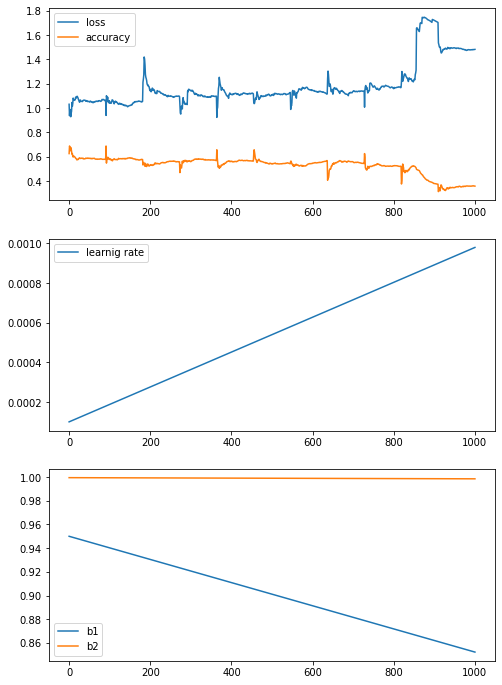

In [272]:
fig, axs = plt.subplots(3, figsize=(8, 12))
axs[0].plot(summary["loss"])
axs[0].plot(summary["accuracy"])
axs[0].legend(["loss", "accuracy"])
axs[1].plot(summary["lrate"])
axs[1].legend(["learnig rate"])
axs[2].plot(summary["b1"])
axs[2].plot(summary["b2"])
axs[2].legend(["b1", "b2"])
plt.show()

##### Note

If RMSprop, adam or nadam not performs well then just swith to plain Nesterov Accelerated Gradient

##### Observations

For small learning rate model jumps around 60% accuracy, so one chance of improving it using smaller learnig rate. Indeed, second option is to change the optimizer as we will be doing now.

In [280]:
class OneCycleSchedulerSGD(keras.callbacks.Callback):
    def __init__(self, iterations, 
                 max_lrate, 
                 start_lrate=None,
                 last_iterations=None, 
                 last_lrate=None,
                 max_momentum=0.95,
                 min_momentum=0.85):
        
        self.iterations = iterations
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        
        self.max_lrate = max_lrate
        self.start_lrate = start_lrate or max_lrate / 10
        self.last_lrate = last_lrate or self.start_lrate / 1000
        
        self.max_momentum = max_momentum
        self.min_momentum = min_momentum
        self.last_momentum = max_momentum
        
        self.iteration = 0
        
        self.rate = []
        self.momentum = []

        self.loss = []
        self.val_loss = []
        self.accuracy = []
        self.val_accuracy = []
    
    def _interpolate(self, iter1, iter2, lrate1, lrate2):
        return ((lrate2 - lrate1) * (self.iteration - iter1)
                / (iter2 - iter1) + lrate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_lrate, self.max_lrate)
            momentum = self._interpolate(0, self.half_iteration, self.max_momentum, self.min_momentum)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_lrate, self.start_lrate)
            momentum = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.min_momentum, self.max_momentum)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_lrate, self.last_lrate)
            momentum = self.last_momentum
            
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)
        K.set_value(self.model.optimizer.momentum, momentum)
        
    def on_batch_end(self, batch, logs):
        self.rate.append(K.get_value(self.model.optimizer.learning_rate))
        self.momentum.append(K.get_value(self.model.optimizer.momentum))

        self.loss.append(logs["loss"])
        self.accuracy.append(logs["sparse_categorical_accuracy"])

In [ ]:
model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v22.h5")
load_model = keras.models.load_model(model_target)
model = keras.models.clone_model(load_model)
model.set_weights(load_model.get_weights())

In [281]:
def compile_model(model):
    optimizer = keras.optimizers.SGD()
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer,
                  metrics=keras.metrics.sparse_categorical_accuracy)

In [282]:
compile_model(model)

In [283]:
model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v22_1c_sgd.h5")

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
early_stop_cb = keras.callbacks.EarlyStopping(patience=10)

callbacks = [checkpoint_cb, early_stop_cb]

In [284]:
epochs = 25
max_learning_rate = 0.01
onecycle_cb = OneCycleSchedulerSGD(int(steps_factor * max_train_instance / batch_size) * epochs, max_lrate=max_learning_rate)

callbacks.append(onecycle_cb)

In [ ]:
history = model.fit(train_set, 
                    epochs=epochs, 
                    steps_per_epoch=int(steps_factor * max_train_instance / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/25
91/91 [==============================] - 144s 2s/step - loss: 1.5157 - sparse_categorical_accuracy: 0.3444 - val_loss: 1.4533 - val_sparse_categorical_accuracy: 0.3894
Epoch 2/25
91/91 [==============================] - 136s 2s/step - loss: 1.4761 - sparse_categorical_accuracy: 0.3606 - val_loss: 1.4109 - val_sparse_categorical_accuracy: 0.3534
Epoch 3/25
91/91 [==============================] - 141s 2s/step - loss: 1.4590 - sparse_categorical_accuracy: 0.3664 - val_loss: 1.3736 - val_sparse_categorical_accuracy: 0.3870
Epoch 4/25
91/91 [==============================] - 145s 2s/step - loss: 1.4263 - sparse_categorical_accuracy: 0.3554 - val_loss: 1.3385 - val_sparse_categorical_accuracy: 0.3774
Epoch 5/25
91/91 [==============================] - 149s 2s/step - loss: 1.4334 - sparse_categorical_accuracy: 0.3499 - val_loss: 1.3384 - val_sparse_categorical_accuracy: 0.4183
Epoch 6/25
91/91 [==============================] - 153s 2s/step - loss: 1.4087 - sparse_categorical_accu